# Создание прототипа модели машинного обучения для оптимизации энергозатрат металлургического предприятия в процессе выплавки легированной стали

Целью проекта является создание прототипа модели машинного обучения, способной  с точностью в пределах +- 6.8 градусоув Цельсия предсказывать температуру расплавленной стали в конце технологического процесса легирования для оптимизации затрат энергии на подогрев плавильного ковша.

Для успешной реализации цели проекта необходимо последовательно осуществить следующие взаимосвязанные задачи:
- Провести исследовательский анализ данных
- Провести предобработку данных (в том числе специфичную для выбранной модели)
- Создать объект модели и настроить гиперпараметры
- Выбрать лучшую модель и апробировать ее на реальных неизмененных данных
- Сделать выводы и сформулировать рекомендации

Условия задания:
- Допустимая погрешность работы модели не более 6.8 по метрике MAE
- Размер тестовой выборки 25%
- Значения температуры ниже 1500 градусов и экстремальные отрицательные значения реактивной мощности считать аномалиями
- random_state определить в виде целого числа 270223

## Описание данных
Данные состоят из файлов, полученных из разных источников:

1. data_arc.csv — данные об электродах;
2. data_bulk.csv — данные о подаче сыпучих материалов (объём);
3. data_bulk_time.csv — данные о подаче сыпучих материалов (время);
4. data_gas.csv — данные о продувке сплава газом;
5. data_temp.csv — результаты измерения температуры;
6. data_wire.csv — данные о проволочных материалах (объём);
7. data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


## Предварительные мероприятия

In [1]:
RANDOM_STATE = 270223
TEST_SIZE = .25
TEMP_LOWER_LIMIT = 1500
REACTIVE_POWER_LOWER_LIMIT = -3

In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn
import plotly
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
from sklearn.ensemble import IsolationForest

from lightgbm import LGBMRegressor

import optuna



In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [4]:
def use(function, *args, **kwargs) -> None:
    """Applies function to data.
    Data is dict of pandas dataframes and meant to be declared globally."""
    if data is None or type(data) is not type({}):
        return
    for key in data.keys():
        print(key)
        display(function(data[key], *args, **kwargs))


def get_hist(values: pd.Series, bins: int = 10, by_first: bool = True) -> None:
    """Displays one-row dataframe representing distribution of values in bins.
    Number more than (if by_first is true) values in columns or vice versa."""
    hist = np.histogram(values, bins=bins)
    if by_first:
        columns = hist[1][:-1]
        print('more than')
    else:
        columns = hist[1][1:]
        print('less than')
    display(pd.DataFrame(data=hist[0].reshape(1, -1), columns=columns))


def get_scores(model, X, y, show=True, simple_response=True) -> float:
    """Displays cross-validation results if 'show'=True and returns the maximum test MAE"""
    cv_result = cross_validate(
        model, X, y, scoring='neg_mean_absolute_error', cv=5, return_train_score=True, n_jobs=-1)
    cv_result['test_score'] *= -1
    cv_result['train_score'] *= -1
    cv_result = pd.DataFrame(cv_result)
    if show:
        display(cv_result.describe())
    elif simple_response:
        return cv_result.test_score.max()
    else:
        return cv_result


def get_corr(data: pd.DataFrame, corr_threshold: float, methods: list[str] = ['pearson', 'spearman', 'kendall']) -> dict:
    """Recursively returns correlation coefficients for the dataframe columns using the passed list of methods with the passed threshold"""
    report = {}
    methods = methods.copy()
    if len(methods) > 0:
        method = methods.pop(0)
        matrix = data.corr(method)
        for i1 in range(len(matrix.columns) - 1):
            for i2 in range(i1+1, len(matrix.columns)):
                column, index = matrix.columns[i1], matrix.index[i2]
                value = matrix.loc[column, index]
                if abs(value) > corr_threshold:
                    report[(column, index, method)] = value
        report.update(get_corr(data, corr_threshold, methods))
    return report


def get_corr_report(data: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """Slightly transforms the output of the 'get_corr' function for a better  user experience"""
    report = get_corr(data, threshold)
    correlations = pd.DataFrame(report.keys(), columns=[
                                'feature1', 'feature2', 'method'])
    correlations['value'] = report.values()
    return correlations


def select_features(model, X, y) -> tuple[float, list[str]]:
    """Selection of the best features based on the multicolinearity principle"""
    best_features_names = []
    score = 100.
    for i in np.arange(.05, 1, .05, ):
        report = get_corr_report(X, i)
        X_selected = X[X.columns[~X.columns.isin(report['feature1'])]]
        if len(X_selected.columns) == 0:
            continue
        result = get_scores(model, X_selected, y, show=False)
        print(i, result)
        if result < score:
            score = result
            best_features_names = X_selected.columns
    return score, best_features_names

## Загрузка и исследование данных

In [5]:
file_names = ['arc', 'bulk', 'bulk_time', 'gas', 'temp', 'wire', 'wire_time']
path = '/datasets/final_steel/'
if os.path.exists(path):
    data = {name: pd.read_csv(f'{path}data_{name}.csv') for name in file_names}
else:
    data = {name: pd.read_csv(f'final_steel\data_{name}.csv')
            for name in file_names}

for key in data.keys():
    print(key, len(data[key]))
    print('unique keys', data[key]['key'].nunique())

arc 14876
unique keys 3214
bulk 3129
unique keys 3129
bulk_time 3129
unique keys 3129
gas 3239
unique keys 3239
temp 15907
unique keys 3216
wire 3081
unique keys 3081
wire_time 3081
unique keys 3081


Ключи повторяются по нескольку раз в датасетах  arc и temp. Множества ключей пересекаются частично

In [6]:
use(pd.DataFrame.head, 10)

arc


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   
5    2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.438063   
6    2  2019-05-03 11:38:50  2019-05-03 11:44:28           1.296415   
7    2  2019-05-03 11:46:19  2019-05-03 11:48:25           0.490377   
8    2  2019-05-03 11:49:48  2019-05-03 11:53:18           0.827743   
9    3  2019-05-03 12:06:54  2019-05-03 12:11:34           1.062053   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397  
5             0.283043  
6             0.892914  
7             0.305281  
8             0.516874  
9             0.671494

bulk


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6    7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7    8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8    9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9   10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6     NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7     NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8     NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9     NaN      NaN      NaN    203.0      NaN    102.0    204.0

bulk_time


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   
5    6    NaN    NaN    NaN  2019-05-03 13:59:24    NaN    NaN    NaN    NaN   
6    7    NaN    NaN    NaN  2019-05-03 14:29:14    NaN    NaN    NaN    NaN   
7    8    NaN    NaN    NaN  2019-05-03 15:04:05    NaN    NaN    NaN    NaN   
8    9    NaN    NaN    NaN  2019-05-03 15:47:34    NaN    NaN    NaN    NaN   
9   10    NaN    NaN    NaN                  NaN    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   
5    NaN     NaN     NaN  2019-05-03 13:53:27     NaN  2019-05-03 13:53:27   
6    NaN     NaN     NaN  2019-05-03 14:22:19     NaN  2019-05-03 14:22:19   
7    NaN     NaN     NaN  2019-05-03 14:55:46     NaN  2019-05-03 14:55:46   
8    NaN     NaN     NaN  2019-05-03 15:41:00     NaN  2019-05-03 15:41:00   
9    NaN     NaN     NaN  2019-05-03 16:18:52     NaN  2019-05-03 16:18:52   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56  
5  2019-05-03 13:53:27  
6  2019-05-03 14:22:19  
7  2019-05-03 14:55:46  
8  2019-05-03 15:41:00  
9  2019-05-03 16:18:52

gas


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267
7    8  15.171553
8    9   8.216623
9   10   6.529891

temp


key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0
5    2  2019-05-03 11:37:27       1581.0
6    2  2019-05-03 11:38:00       1577.0
7    2  2019-05-03 11:49:38       1589.0
8    2  2019-05-03 11:55:50       1604.0
9    2  2019-05-03 11:58:24       1608.0

wire


key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1   60.059998        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2   96.052315        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3   91.160157        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4   89.063515        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5   89.238236   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
5    6   99.109917   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
6    7   98.061600        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7    8  155.282394        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8    9  113.393279   9.143681     NaN     NaN     NaN     NaN     NaN     NaN   
9   10   81.244796  12.376000     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN

wire_time


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:59:02  2019-05-03 13:59:54    NaN    NaN    NaN    NaN   
6    7  2019-05-03 14:28:46                  NaN    NaN    NaN    NaN    NaN   
7    8  2019-05-03 15:03:42                  NaN    NaN    NaN    NaN    NaN   
8    9  2019-05-03 15:42:43  2019-05-03 15:58:12    NaN    NaN    NaN    NaN   
9   10  2019-05-03 16:20:25  2019-05-03 16:21:02    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
5    NaN    NaN    NaN  
6    NaN    NaN    NaN  
7    NaN    NaN    NaN  
8    NaN    NaN    NaN  
9    NaN    NaN    NaN

В датасетах со временем и объемом bulk  и wire большое количество пропусков, вероятно неслучайных и могущих быть замененными нулями

In [7]:
use(pd.DataFrame.info)

arc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

bulk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

bulk_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

gas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

temp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

wire
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

wire_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Поля поименованы нестандартно, дата и время хранятся в полях типа "object", что может быть оптимизировано для снижения объема занимаемой памяти

In [8]:
use(pd.DataFrame.describe, include='all')

arc


key Начало нагрева дугой  Конец нагрева дугой  \
count   14876.000000                14876                14876   
unique           NaN                14875                14876   
top              NaN  2019-06-10 22:02:03  2019-05-03 11:06:02   
freq             NaN                    2                    1   
mean     1615.220422                  NaN                  NaN   
std       934.571502                  NaN                  NaN   
min         1.000000                  NaN                  NaN   
25%       806.000000                  NaN                  NaN   
50%      1617.000000                  NaN                  NaN   
75%      2429.000000                  NaN                  NaN   
max      3241.000000                  NaN                  NaN   

        Активная мощность  Реактивная мощность  
count        14876.000000         14876.000000  
unique                NaN                  NaN  
top                   NaN                  NaN  
freq                  NaN                  NaN  
mean             0.670441             0.452592  
std              0.408159             5.878702  
min              0.030002          -715.504924  
25%              0.395297             0.290991  
50%              0.555517             0.415962  
75%              0.857034             0.637371  
max              3.731596             2.676388

bulk


key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

bulk_time


key               Bulk 1               Bulk 2  \
count   3129.000000                  252                   22   
unique          NaN                  252                   22   
top             NaN  2019-05-03 17:50:19  2019-05-07 08:36:19   
freq            NaN                    1                    1   
mean    1624.383509                  NaN                  NaN   
std      933.337642                  NaN                  NaN   
min        1.000000                  NaN                  NaN   
25%      816.000000                  NaN                  NaN   
50%     1622.000000                  NaN                  NaN   
75%     2431.000000                  NaN                  NaN   
max     3241.000000                  NaN                  NaN   

                     Bulk 3               Bulk 4               Bulk 5  \
count                  1298                 1014                   77   
unique                 1298                 1014                   77   
top     2019-05-03 20:13:36  2019-05-03 11:21:30  2019-05-07 08:36:19   
freq                      1                    1                    1   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                     NaN                  NaN                  NaN   
50%                     NaN                  NaN                  NaN   
75%                     NaN                  NaN                  NaN   
max                     NaN                  NaN                  NaN   

                     Bulk 6               Bulk 7               Bulk 8  \
count                   576                   25                    1   
unique                  576                   25                    1   
top     2019-05-03 18:52:57  2019-05-07 11:37:42  2019-07-05 17:46:11   
freq                      1                    1                    1   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                     NaN                  NaN                  NaN   
50%                     NaN                  NaN                  NaN   
75%                     NaN                  NaN                  NaN   
max                     NaN                  NaN                  NaN   

                     Bulk 9              Bulk 10              Bulk 11  \
count                    19                  176                  177   
unique                   19                  176                  177   
top     2019-05-14 00:04:56  2019-05-06 01:36:24  2019-05-05 16:45:05   
freq                      1                    1                    1   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                     NaN                  NaN                  NaN   
50%                     NaN                  NaN                  NaN   
75%                     NaN                  NaN                  NaN   
max                     NaN                  NaN                  NaN   

                    Bulk 12              Bulk 13              Bulk 14  \
count                  2450                   18                 2806   
unique                 2450                   18                 2806   
top     2019-05-03 11:03:52  2019-05-05 00:39:35  2019-05-03 11:03:52   
freq                      1                    1                    1   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                 

gas


key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

temp


key         Время замера   Температура
count   15907.000000                15907  13006.000000
unique           NaN                15907           NaN
top              NaN  2019-05-03 11:16:18           NaN
freq             NaN                    1           NaN
mean     1607.880870                  NaN   1591.840920
std       942.212073                  NaN     21.375851
min         1.000000                  NaN   1191.000000
25%       790.000000                  NaN   1581.000000
50%      1618.000000                  NaN   1591.000000
75%      2427.000000                  NaN   1601.000000
max      3241.000000                  NaN   1705.000000

wire


key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

wire_time


key               Wire 1               Wire 2  \
count   3081.000000                 3055                 1079   
unique          NaN                 3055                 1079   
top             NaN  2019-05-03 11:11:41  2019-05-03 13:32:06   
freq            NaN                    1                    1   
mean    1623.426485                  NaN                  NaN   
std      932.996726                  NaN                  NaN   
min        1.000000                  NaN                  NaN   
25%      823.000000                  NaN                  NaN   
50%     1619.000000                  NaN                  NaN   
75%     2434.000000                  NaN                  NaN   
max     3241.000000                  NaN                  NaN   

                     Wire 3               Wire 4               Wire 5  \
count                    63                   14                    1   
unique                   63                   14                    1   
top     2019-05-04 04:47:53  2019-05-07 08:48:23  2019-08-08 16:01:07   
freq                      1                    1                    1   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                     NaN                  NaN                  NaN   
50%                     NaN                  NaN                  NaN   
75%                     NaN                  NaN                  NaN   
max                     NaN                  NaN                  NaN   

                     Wire 6               Wire 7               Wire 8  \
count                    73                   11                   19   
unique                   73                   11                   19   
top     2019-05-07 08:37:20  2019-07-23 12:42:00  2019-05-14 00:03:32   
freq                      1                    1                    1   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                     NaN                  NaN                  NaN   
50%                     NaN                  NaN                  NaN   
75%                     NaN                  NaN                  NaN   
max                     NaN                  NaN                  NaN   

                     Wire 9  
count                    29  
unique                   29  
top     2019-05-04 16:09:11  
freq                      1  
mean                    NaN  
std                     NaN  
min                     NaN  
25%                     NaN  
50%                     NaN  
75%                     NaN  
max                     NaN

В датасете arc в поле "Реактивная мощность" присутствуют аномалии в виде сильно отрицательных значений. В датасете temp присутствуют температуры ниже 1500,  исключаемые по условию задачи.

### Пропуски

In [9]:
for key in data.keys():
    print(key)
    display(data[key].isna().sum())

arc


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

bulk


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

bulk_time


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

gas


key      0
Газ 1    0
dtype: int64

temp


key                0
Время замера       0
Температура     2901
dtype: int64

wire


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

wire_time


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество пропусков соответствует попарно в датасетах bulk и bulk_time и wire и wire_time, что явно свидетельствует об их технологическом происхождении.  Пропуски в поле "Температура" датасета temp должны быть рассмотрены подробнее - они могут оказаться на месте последнего замера температуры, то есть целевого признака, и не смогут быть восстановлены

### Явные дубликаты

In [10]:
for key in data.keys():
    print(key)
    display(data[key].duplicated().sum())

arc


0

bulk


0

bulk_time


0

gas


0

temp


0

wire


0

wire_time


0

Явные дубликаты отсутствуют

### Повторяющиеся номера партии

In [11]:
def count_iterations(dataset_name):
    iterations = data[dataset_name].key.value_counts()
    iterations = iterations.groupby(
        iterations).count().sort_values(ascending=False)
    iterations = pd.DataFrame(
        {'iterations': iterations.index, 'number': iterations.values})
    display(iterations)


count_iterations('arc')

iterations  number
0            4     892
1            5     759
2            3     520
3            6     490
4            7     205
5            2     174
6            8      84
7            1      39
8            9      28
9           10       9
10          11       5
11          12       3
12          13       2
13          15       2
14          14       1
15          16       1

In [12]:
count_iterations('temp')

iterations  number
0            4     862
1            5     759
2            3     545
3            6     473
4            7     240
5            8     128
6            2      78
7            9      57
8           10      27
9           11      21
10          12      14
11          16       4
12          13       3
13           1       2
14          15       2
15          14       1

Количество итераций, в которое осуществляется технологический процесс,  от одной до шестнадцати, распределение напоминает нормальное, но с длинным правым хвостом, с вершиной в районе четырех-пяти. 
Это может быть проинтерпретировано так, что процесс действительно далеко неоптимален (запрос заказчика оправдан), но при этом все же не носит полностью стохастический характер.

### Выявление аномалий


Активная мощность
more than


0.030002  0.400161  0.770321  1.140480  1.510640  1.880799  2.250958  \
0      3833      6399      2808      1203       387       155        58   

   2.621118  2.991277  3.361437  
0        26         6         1

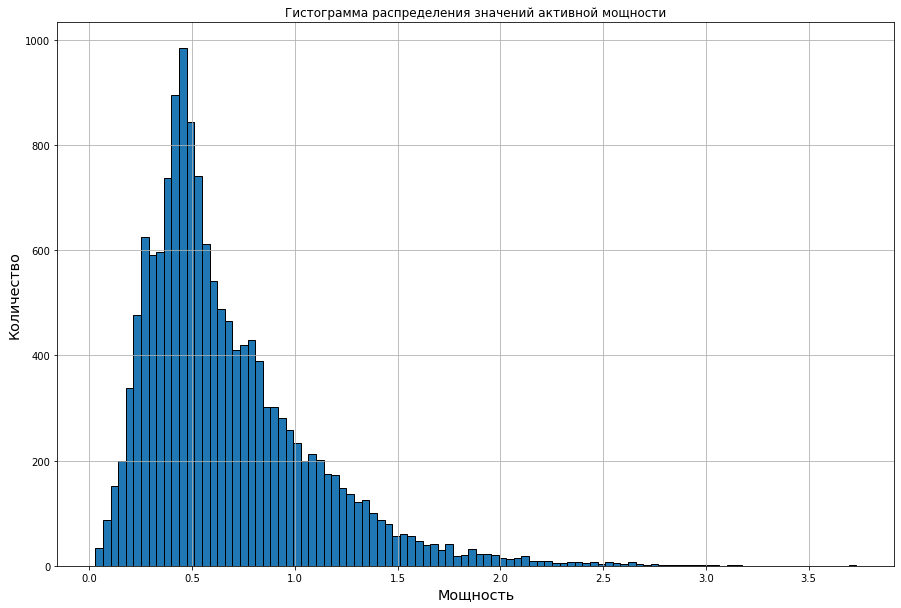

In [13]:
active_power = data['arc']['Активная мощность']
print('Активная мощность')
get_hist(active_power)

plt.figure(figsize=(15, 10))
active_power.plot.hist(bins=100, grid=True, edgecolor='black')
plt.title('Гистограмма распределения значений активной мощности')
plt.xlabel('Мощность', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

Реактивная мощность
more than


-715.504924  -643.686793  -571.868662  -500.050531  -428.232399  \
0            1            0            0            0            0   

   -356.414268  -284.596137  -212.778006  -140.959875  -69.141744   
0            0            0            0            0        14875

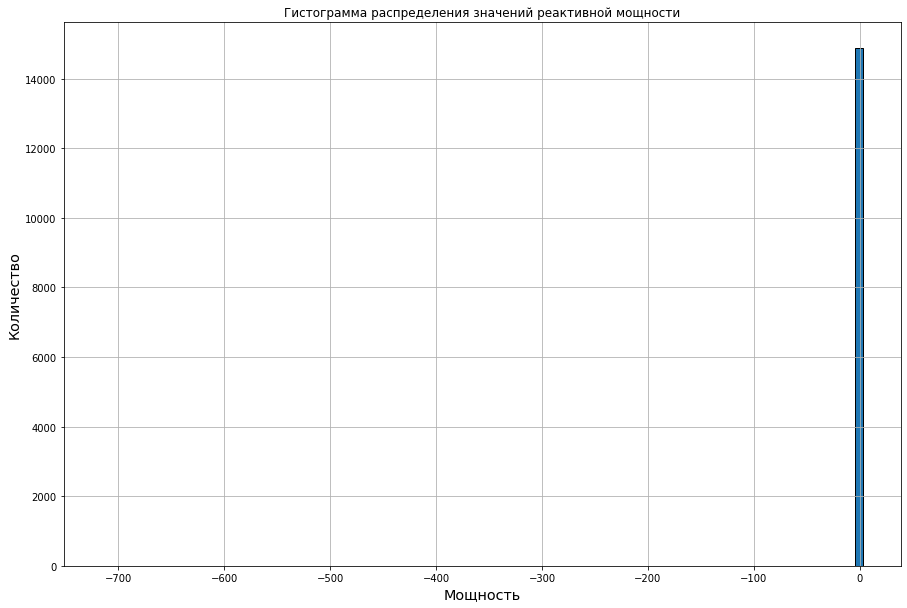

In [14]:
reactive_power = data['arc']['Реактивная мощность']
print('Реактивная мощность')
get_hist(reactive_power)

plt.figure(figsize=(15, 10))
reactive_power.plot.hist(bins=100, grid=True, edgecolor='black')
plt.title('Гистограмма распределения значений реактивной мощности')
plt.xlabel('Мощность', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

more than


0.020806  0.286364  0.551923  0.817481  1.083039  1.348597  1.614155  \
0      3619      6324      2862      1282       467       183        90   

   1.879713  2.145271  2.410829  
0        37         8         3

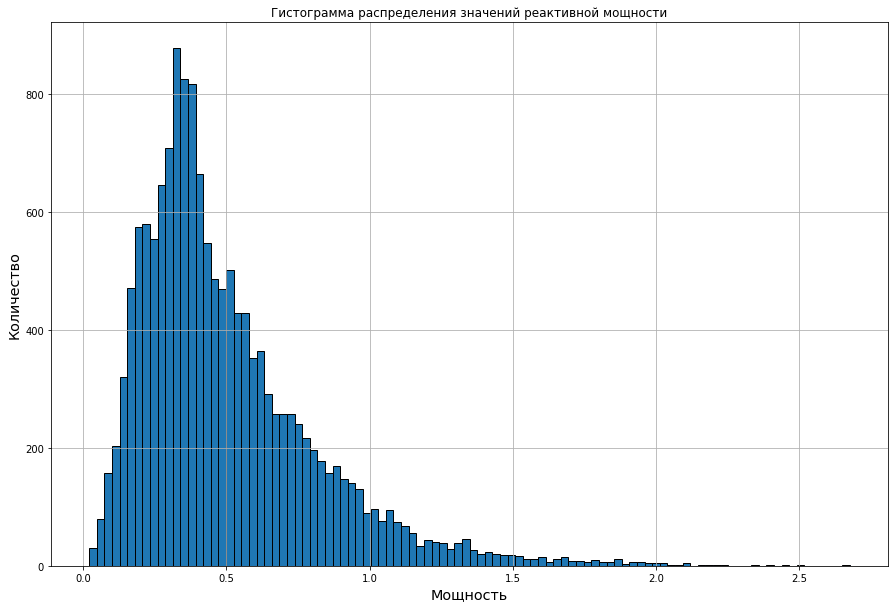

In [15]:
reactive_power = reactive_power[reactive_power > -650]
get_hist(reactive_power)

plt.figure(figsize=(15, 10))
reactive_power.plot.hist(bins=100, grid=True, edgecolor='black')
plt.title('Гистограмма распределения значений реактивной мощности')
plt.xlabel('Мощность', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

Температура
less than


1208.133333  1225.266667  1242.400000  1259.533333  1276.666667  \
0            3            1            1            0            0   

   1293.800000  1310.933333  1328.066667  1345.200000  1362.333333  \
0            0            0            0            0            0   

   1379.466667  1396.600000  1413.733333  1430.866667  1448.000000  \
0            0            2            0            0            0   

   1465.133333  1482.266667  1499.400000  1516.533333  1533.666667  \
0            0            0            0            0           31   

   1550.800000  1567.933333  1585.066667  1602.200000  1619.333333  \
0          210          796         3497         5531         1969   

   1636.466667  1653.600000  1670.733333  1687.866667  1705.000000  
0          587          239           89           41            9

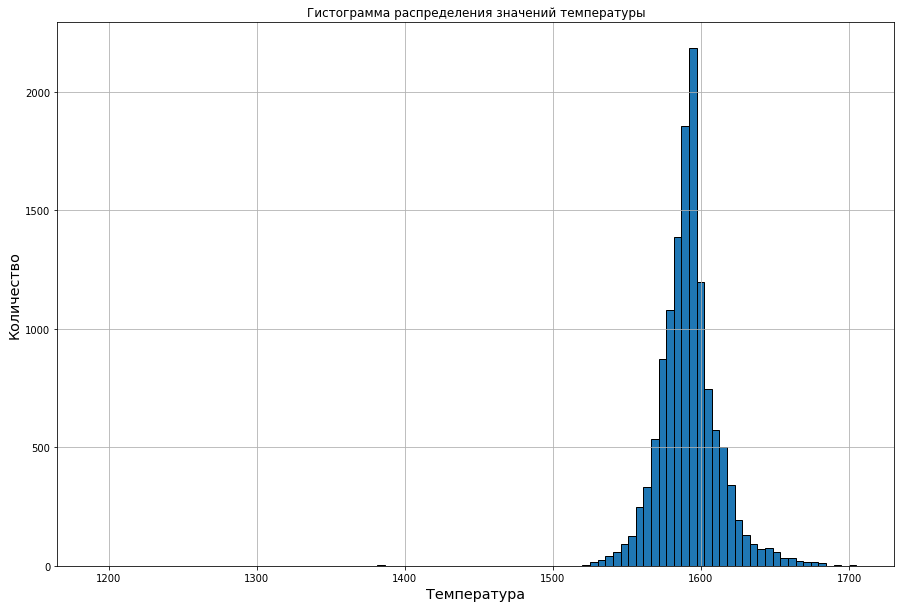

In [16]:
temperature = data['temp'][data['temp']['Температура'].notna()]['Температура']
print('Температура')
get_hist(temperature, bins=30, by_first=False)

plt.figure(figsize=(15, 10))
temperature.plot.hist(bins=100, grid=True, edgecolor='black')
plt.title('Гистограмма распределения значений температуры')
plt.xlabel('Температура', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

Газ
more than


0.008399   3.127864   6.247330   9.366795   12.486261  15.605727  \
0        159        435        895        740        438        260   

   18.725192  21.844658  24.964124  28.083589  31.203055  34.322521  \
0        128         81         37         32         17          4   

   37.441986  40.561452  43.680918  46.800383  49.919849  53.039314  \
0          5          2          1          0          3          0   

   56.158780  59.278246  62.397711  65.517177  68.636643  71.756108  74.875574  
0          0          1          0          0          0          0          1

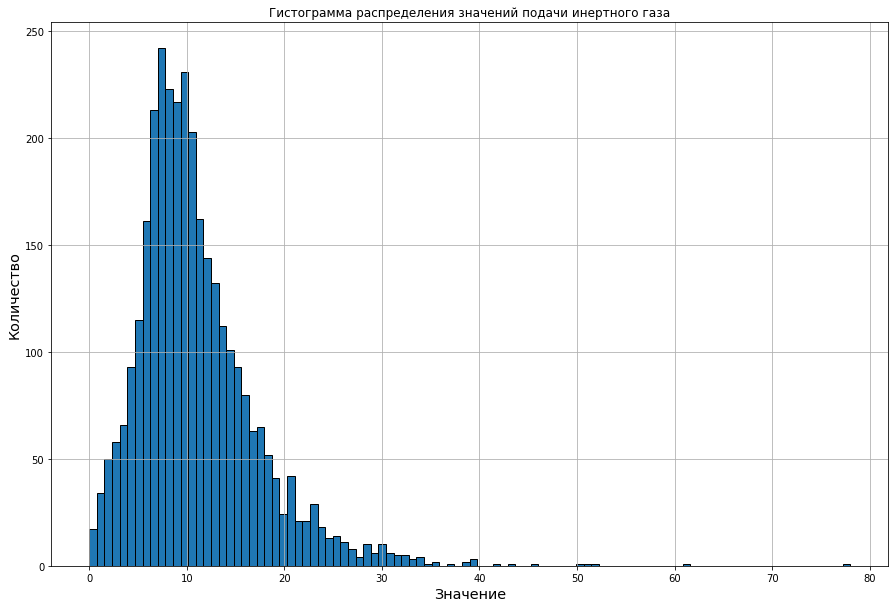

In [17]:
gas = data['gas']['Газ 1']
print('Газ')
get_hist(gas, bins=25)

plt.figure(figsize=(15, 10))
gas.plot.hist(bins=100, grid=True, edgecolor='black')
plt.title('Гистограмма распределения значений подачи инертного газа')
plt.xlabel('Значение', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

В данных по реактивной мощности и температуре присутствует несколько аномалий в заданных по условию границах исключения - единственное экстремально отрицательное значение реактивной мощности и несколько температур ниже полутора тысяч градусов. 
В данных по инертному газу  также есть явная аномалия  (или выброс) на верхней границе диапазона значений.
Прочие записи все так же красноречиво свидетельствуют о неоптимальности процесса - в ряде случаев приходится подавать большую мощность на электроды, что приводит к перерасходу электроэнергии, то же происходит и в отношении использования газа.

### Выводы по этапу исследовательского анализа данных

На основе проведенного  анализа было установлено следующее:
- Данные распределены по семи датасетам с разным количеством записей
- Особенностью является то, что
    - в пяти датасетах ключ (номер партии) уникален
    - в двух других этот же ключ повторяется согласно итерационному характеру процесса, уникальными при этом являются временные метки
- В данных присутствуют пропуски двух типов:
    - технологические 
    - вероятно появившиеся в результате воздействия случайных факторов
- В датасетах arc, temp, gas присутствуют аномалии
- Данные в этих датасетах обладают длинной и узкой хвостовой частью справа
- Медианное и среднее значение совпадает в этих датасетах везде, кроме распределения данных  по активной мощности и использованию инертного газа, что может подтвердить перерасход ресурсов
- Явные дубликаты отсутствуют
- Вершина распределения количества итераций технологического  процесса находится в районе четырех-пяти при широте диапазона от одной до шестнадцати, распределение обладает достаточно широким правым хвостом, что в совокупности говорит о большом количестве неудачных плавок и недостаточной оптимальности в целом управляемого процесса
- Данные могут быть оптимизированы в отношении типов  и стандарта именования
- Для обучения модели данные требуют предобработки



## План дальнейших действий

Учитывая изложенное, планируется на следующих этапах провести такие мероприятия:
1. Исправить нестандартное именование столбцов в итоговом датасете
2. Привести временные метки к соответствующему типу
3. Удалить  аномалии и экстремальные значения в датасетах arc, temp, gas и ограничить:
    - реактивная мощность выше -3
    - температура выше 1500
4. В датасетах bulk и wire заполнить пропуски нулями
5. Дополнить данные в датасете arc вычисляемыми признаками:
    - полная мощность - корень квадратный из суммы квадратов активной и реактивной мощностей
    - отношение активной и реактивной мощности
    - полезноре время работы (произведение активной мощности  и времени)
6. Сагрегировать признаки для одной партии
7. В датасете temp выделить целевой признак (конечная температура)
8. Объединить данные для обучения в один датасет
    - Скомпенсировать разная количество записей в датасетах в процессе их  объединения по типу inner join
9. Затем приступить к созданию и обучению моделей:
    - Гребневой регрессии
    - LGBM
10. При этом необъходимым дополнительным этапом для работы с моделью на основе гребневой регрессии является исследование  подготовленных данных на  мультиколинеарномсть  и соответствующая дополнительная обработка
11. Далее провести настройку гиперпараметров с помощью инструмента optuna
12. На основе результатов кросс-валидации  выбрать лучшую модель и проверить ее на тестовой выборке
13. Описать выводы и сделать рекомендации


## Предобработка данных

### Технологичски процесс в виде сводной таблицы
Прежде чем приступить к обработке данных, взглянем, как построен собственно технологический процесс. Для этого создадим сводную таблицу с ключом, временем и меткой действия

In [18]:
def get_timestamps(df: pd.DataFrame, label: str) -> pd.DataFrame:
    tmp = df.copy()
    keys = np.array([np.ones(len(tmp.columns) - 1) +
                    i for i in range(len(tmp))]).flatten()
    values = (tmp.values[:, 1:]).flatten()
    result = pd.DataFrame({'key': keys, 'time': values, 'label': label})\
        .dropna().reset_index(drop=True)
    return result


timestamps = get_timestamps(data['wire_time'], 'wire')
timestamps = pd.concat([timestamps, get_timestamps(data['bulk_time'], 'bulk')])
arc_on_timestamps = data['arc'][['key', 'Начало нагрева дугой']].rename(
    columns={'Начало нагрева дугой': 'time'})
arc_on_timestamps['label'] = 'arc_on'
timestamps = pd.concat([timestamps, arc_on_timestamps])
arc_off_timestamps = data['arc'][['key', 'Конец нагрева дугой']].rename(
    columns={'Конец нагрева дугой': 'time'})
arc_off_timestamps['label'] = 'arc_off'
timestamps = pd.concat([timestamps, arc_off_timestamps])
temp_timestamps = data['temp'][['key', 'Время замера']].rename(
    columns={'Время замера': 'time'})
temp_timestamps['label'] = 'temp'
timestamps = pd.concat([timestamps, temp_timestamps])
timestamps['key'] = timestamps.key.astype(int)
timestamps['time'] = pd.to_datetime(timestamps.time)
timestamps = timestamps.sort_values(['key', 'time']).reset_index(drop=True)
timestamps.head(50)

key                time    label
0     1 2019-05-03 11:02:14   arc_on
1     1 2019-05-03 11:03:52     bulk
2     1 2019-05-03 11:03:52     bulk
3     1 2019-05-03 11:03:52     bulk
4     1 2019-05-03 11:06:02  arc_off
5     1 2019-05-03 11:07:28   arc_on
6     1 2019-05-03 11:10:33  arc_off
7     1 2019-05-03 11:11:41     wire
8     1 2019-05-03 11:11:44   arc_on
9     1 2019-05-03 11:14:36  arc_off
10    1 2019-05-03 11:16:18     temp
11    1 2019-05-03 11:18:14   arc_on
12    1 2019-05-03 11:21:30     bulk
13    1 2019-05-03 11:24:19  arc_off
14    1 2019-05-03 11:25:53     temp
15    1 2019-05-03 11:26:09   arc_on
16    1 2019-05-03 11:28:37  arc_off
17    1 2019-05-03 11:29:11     temp
18    1 2019-05-03 11:30:01     temp
19    1 2019-05-03 11:30:39     temp
20    2 2019-05-03 11:34:14   arc_on
21    2 2019-05-03 11:36:31  arc_off
22    2 2019-05-03 11:37:27     temp
23    2 2019-05-03 11:38:00     temp
24    2 2019-05-03 11:38:50   arc_on
25    2 2019-05-03 11:40:20     bulk
26    2 2019-05-03 11:40:20     bulk
27    2 2019-05-03 11:40:20     bulk
28    2 2019-05-03 11:44:28  arc_off
29    2 2019-05-03 11:46:10     wire
30    2 2019-05-03 11:46:19   arc_on
31    2 2019-05-03 11:46:38     bulk
32    2 2019-05-03 11:48:25  arc_off
33    2 2019-05-03 11:49:38     temp
34    2 2019-05-03 11:49:48   arc_on
35    2 2019-05-03 11:53:18  arc_off
36    2 2019-05-03 11:55:50     temp
37    2 2019-05-03 11:58:24     temp
38    2 2019-05-03 11:59:12     temp
39    3 2019-05-03 12:06:54   arc_on
40    3 2019-05-03 12:09:40     bulk
41    3 2019-05-03 12:09:40     bulk
42    3 2019-05-03 12:09:40     bulk
43    3 2019-05-03 12:11:34  arc_off
44    3 2019-05-03 12:13:17     temp
45    3 2019-05-03 12:13:47     wire
46    3 2019-05-03 12:13:52   arc_on
47    3 2019-05-03 12:15:56  arc_off
48    3 2019-05-03 12:18:36     temp
49    3 2019-05-03 12:18:56   arc_on

Тонкости управления плавкой требуют более глубокого изучения, однако по первым же записям создается впечатление, что этот процесс зависит от многих факторов и набор необходимых решений далек от шаблонного. 
Модель машинного обучения, предоставляющая информацию о конечной температуре, без сомнения послужит хорошим инструментом для более надежного управления этим процессом

### Обработка признаков
На данном шаге нам предстоит извлечь признаки из датасетов с повторяющимися ключами.
Во избежание подгонки результата работы будущей модели из датасета с температурой возьмем только конечное значение, собственно целевой признак, и изначальную температуру.
Кроме того, используем в качестве дополнительного признака количество итераций и  измерения температуры.
Необходимо сгруппировать данные по ключу и времени и взять первое и последнее значение температуры из группы, предварительно удалив полностью ключи с одиночным значением, как неинформативные.
В датасете с данными по электродам промежуточные записи активной и реактивной мощности обработаем несколькими вариантами агрегирующих функций, а перед тем добавим несколько вычисляемых признаков - полную мощность, полезное время работы и отношение активной мощности к реактивной. Также возьмем количество итераций для ключа


In [19]:
data_temp = data['temp'].copy()
data_temp['total_iterations'] = data_temp.groupby(
    'key')['key'].transform('count')
data_temp['time'] = pd.to_datetime(data_temp['Время замера'])
data_temp = data_temp.drop(columns=['Время замера']).rename(
    columns={'Температура': 'temperature'}).sort_values(['key', 'time'])
outliers = set(data_temp[data_temp['temperature'] < TEMP_LOWER_LIMIT]['key'])
data_temp = data_temp[~data_temp.key.isin(outliers)]
data_temp = data_temp[data_temp['total_iterations'] > 1]
print(
    f"Сохранилось данных: {np.round((len(data_temp) / len(data['temp'])) * 100, 2)}%")
data_temp['iteration'] = data['temp'].groupby('key')['key'].cumcount()
data_temp['final_temp'] = data_temp['iteration'] == data_temp['total_iterations'] - 1
data_temp['initial_temp'] = data_temp['iteration'] == 0
data_temp.head(30)

Сохранилось данных: 99.67%


key  temperature  total_iterations                time  iteration  \
0     1       1571.0                 5 2019-05-03 11:16:18          0   
1     1       1604.0                 5 2019-05-03 11:25:53          1   
2     1       1618.0                 5 2019-05-03 11:29:11          2   
3     1       1601.0                 5 2019-05-03 11:30:01          3   
4     1       1613.0                 5 2019-05-03 11:30:39          4   
5     2       1581.0                 6 2019-05-03 11:37:27          0   
6     2       1577.0                 6 2019-05-03 11:38:00          1   
7     2       1589.0                 6 2019-05-03 11:49:38          2   
8     2       1604.0                 6 2019-05-03 11:55:50          3   
9     2       1608.0                 6 2019-05-03 11:58:24          4   
10    2       1602.0                 6 2019-05-03 11:59:12          5   
11    3       1596.0                 5 2019-05-03 12:13:17          0   
12    3       1597.0                 5 2019-05-03 12:18:36          1   
13    3       1598.0                 5 2019-05-03 12:25:06          2   
14    3       1599.0                 5 2019-05-03 12:30:48          3   
15    3       1599.0                 5 2019-05-03 12:34:57          4   
16    4       1601.0                 3 2019-05-03 12:52:57          0   
17    4       1623.0                 3 2019-05-03 12:58:43          1   
18    4       1625.0                 3 2019-05-03 12:59:25          2   
19    5       1576.0                 2 2019-05-03 13:23:19          0   
20    5       1602.0                 2 2019-05-03 13:36:01          1   
21    6       1543.0                 5 2019-05-03 13:49:24          0   
22    6       1581.0                 5 2019-05-03 14:04:31          1   
23    6       1600.0                 5 2019-05-03 14:11:11          2   
24    6       1600.0                 5 2019-05-03 14:11:50          3   
25    6       1596.0                 5 2019-05-03 14:12:29          4   
26    7       1586.0                 5 2019-05-03 14:19:43          0   
27    7       1582.0                 5 2019-05-03 14:20:19          1   
28    7       1599.0                 5 2019-05-03 14:32:07          2   
29    7       1595.0                 5 2019-05-03 14:38:48          3   

    final_temp  initial_temp  
0        False          True  
1        False         False  
2        False         False  
3        False         False  
4         True         False  
5        False          True  
6        False         False  
7        False         False  
8        False         False  
9        False         False  
10        True         False  
11       False          True  
12       False         False  
13       False         False  
14       False         False  
15        True         False  
16       False          True  
17       False         False  
18        True         False  
19       False          True  
20        True         False  
21       False          True  
22       False         False  
23       False         False  
24       False         False  
25        True         False  
26       False          True  
27       False         False  
28       False         False  
29       False         False

In [20]:
print('Ключей удалено:', len(outliers))

Ключей удалено: 6


Попутно можно взглянуть, как меняется температура в жизненном цикле каждого ключа:

In [21]:
data_temp.pivot(index='key', columns='iteration',
                values='temperature').head(30)

iteration      0       1       2       3       4       5       6       7   \
key                                                                         
1          1571.0  1604.0  1618.0  1601.0  1613.0     NaN     NaN     NaN   
2          1581.0  1577.0  1589.0  1604.0  1608.0  1602.0     NaN     NaN   
3          1596.0  1597.0  1598.0  1599.0  1599.0     NaN     NaN     NaN   
4          1601.0  1623.0  1625.0     NaN     NaN     NaN     NaN     NaN   
5          1576.0  1602.0     NaN     NaN     NaN     NaN     NaN     NaN   
6          1543.0  1581.0  1600.0  1600.0  1596.0     NaN     NaN     NaN   
7          1586.0  1582.0  1599.0  1595.0  1599.0     NaN     NaN     NaN   
8          1577.0  1604.0  1600.0  1598.0     NaN     NaN     NaN     NaN   
9          1587.0  1589.0  1597.0  1589.0  1592.0     NaN     NaN     NaN   
10         1574.0  1580.0  1585.0  1586.0  1586.0  1586.0  1588.0  1593.0   
11         1616.0  1608.0  1583.0  1597.0     NaN     NaN     NaN     NaN   
12         1606.0  1606.0  1585.0  1588.0  1584.0  1595.0  1591.0     NaN   
13         1596.0  1602.0  1610.0  1613.0  1621.0  1615.0  1619.0     NaN   
14         1583.0  1581.0  1602.0  1596.0  1600.0  1606.0     NaN     NaN   
15         1605.0  1607.0  1611.0  1613.0  1599.0  1598.0     NaN     NaN   
16         1581.0  1590.0  1609.0  1607.0     NaN     NaN     NaN     NaN   
17         1611.0  1611.0  1596.0  1591.0  1599.0  1599.0     NaN     NaN   
18         1588.0  1600.0  1593.0  1592.0  1604.0  1598.0  1595.0     NaN   
19         1625.0  1616.0  1610.0  1605.0  1603.0  1598.0  1604.0  1597.0   
20         1582.0  1584.0  1608.0  1597.0  1603.0     NaN     NaN     NaN   
21         1603.0  1579.0  1581.0  1626.0  1617.0  1615.0  1609.0  1623.0   
22         1560.0  1563.0  1594.0  1598.0  1597.0  1593.0     NaN     NaN   
23         1611.0  1595.0  1612.0  1607.0  1590.0  1593.0     NaN     NaN   
24         1578.0  1584.0  1594.0  1566.0  1572.0  1585.0     NaN     NaN   
25         1594.0  1579.0  1576.0  1575.0  1596.0  1594.0  1595.0  1600.0   
26         1609.0  1587.0  1592.0  1591.0  1601.0     NaN     NaN     NaN   
27         1578.0  1591.0  1604.0     NaN     NaN     NaN     NaN     NaN   
28         1580.0  1603.0  1603.0  1603.0  1611.0  1614.0  1609.0     NaN   
29         1613.0  1605.0  1600.0  1600.0     NaN     NaN     NaN     NaN   
30         1567.0  1567.0  1562.0  1587.0  1605.0  1606.0  1606.0  1598.0   

iteration      8   9   10  11  12  13  14  15  
key                                            
1             NaN NaN NaN NaN NaN NaN NaN NaN  
2             NaN NaN NaN NaN NaN NaN NaN NaN  
3             NaN NaN NaN NaN NaN NaN NaN NaN  
4             NaN NaN NaN NaN NaN NaN NaN NaN  
5             NaN NaN NaN NaN NaN NaN NaN NaN  
6             NaN NaN NaN NaN NaN NaN NaN NaN  
7             NaN NaN NaN NaN NaN NaN NaN NaN  
8             NaN NaN NaN NaN NaN NaN NaN NaN  
9             NaN NaN NaN NaN NaN NaN NaN NaN  
10            NaN NaN NaN NaN NaN NaN NaN NaN  
11            NaN NaN NaN NaN NaN NaN NaN NaN  
12            NaN NaN NaN NaN NaN NaN NaN NaN  
13            NaN NaN NaN NaN NaN NaN NaN NaN  
14            NaN NaN NaN NaN NaN NaN NaN NaN  
15            NaN NaN NaN NaN NaN NaN NaN NaN  
16            NaN NaN NaN NaN NaN NaN NaN NaN  
17            NaN NaN NaN NaN NaN NaN NaN NaN  
18            NaN NaN NaN NaN NaN NaN NaN NaN  
19            NaN NaN NaN NaN NaN NaN NaN NaN  
20            NaN NaN NaN NaN NaN NaN NaN NaN  
21         1618.0 NaN NaN NaN NaN NaN NaN NaN  
22            NaN NaN NaN NaN NaN NaN NaN NaN  
23            NaN NaN NaN NaN NaN NaN NaN NaN  
24            NaN NaN NaN NaN NaN NaN NaN NaN  
25            NaN NaN NaN NaN NaN NaN NaN NaN  
26            NaN NaN NaN NaN NaN NaN NaN NaN  
27            NaN NaN NaN NaN NaN NaN NaN NaN  
28            NaN NaN NaN NaN NaN NaN NaN NaN  
29            NaN NaN NaN NaN NaN NaN NaN NaN  
30            NaN NaN NaN NaN NaN NaN NaN NaN

In [22]:
data_temp.isna().sum()

key                    0
temperature         2896
total_iterations       0
time                   0
iteration              0
final_temp             0
initial_temp           0
dtype: int64

У нас много пропусков в температурном признаке, которые не обязательно окажутся среди последних и первых, но в любом случае будут удалены

In [23]:
# Подготовка датасета для обучения модели
initial_temp = data_temp[data_temp.initial_temp][[
    'key', 'temperature']].set_index('key')
final_temp = data_temp[data_temp.final_temp][[
    'key', 'temperature']].set_index('key').dropna()
iter_temp = data_temp.groupby('key', as_index=True).agg(
    iter_temp=('key', 'count'))
temps = initial_temp.join(final_temp, how='inner', lsuffix='_initial',
                          rsuffix='_final').join(iter_temp, how='inner')
temps.shape

(2470, 3)

In [24]:
temps.head()

temperature_initial  temperature_final  iter_temp
key                                                   
1                 1571.0             1613.0          5
2                 1581.0             1602.0          6
3                 1596.0             1599.0          5
4                 1601.0             1625.0          3
5                 1576.0             1602.0          2

Данные по температуре готовы, переходим к электродам

### Добавление вычисляемых признаков и агрегация

In [25]:
data_arc = data['arc'].copy()
data_arc.columns = ['key', 'start_time',
                    'end_time', 'active_power', 'reactive_power']
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'])
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'])
outliers = set(data_arc[data_arc.reactive_power <
               REACTIVE_POWER_LOWER_LIMIT]['key'])
data_arc = data_arc[~data_arc.key.isin(outliers)]
print(
    f"Сохранилось данных: {np.round((len(data_arc) / len(data['arc'])) * 100, 2)}%")
data_arc['time_interval_sec'] = (
    data_arc.end_time - data_arc.start_time).dt.seconds
data_arc['useful_time'] = data_arc.active_power * data_arc.time_interval_sec
data_arc['full_power'] = np.sqrt(
    data_arc.active_power ** 2 + data_arc.reactive_power ** 2)
data_arc['active_to_reactive'] = data_arc.active_power / \
    data_arc.reactive_power
#data_arc['av_power'] = (data_arc.active_power + data_arc.reactive_power) / 2
data_arc = data_arc.sort_values(['key', 'start_time']).set_index('key')
data_arc.head(30)

Сохранилось данных: 99.97%


start_time            end_time  active_power  reactive_power  \
key                                                                         
1   2019-05-03 11:02:14 2019-05-03 11:06:02      0.976059        0.687084   
1   2019-05-03 11:07:28 2019-05-03 11:10:33      0.805607        0.520285   
1   2019-05-03 11:11:44 2019-05-03 11:14:36      0.744363        0.498805   
1   2019-05-03 11:18:14 2019-05-03 11:24:19      1.659363        1.062669   
1   2019-05-03 11:26:09 2019-05-03 11:28:37      0.692755        0.414397   
2   2019-05-03 11:34:14 2019-05-03 11:36:31      0.438063        0.283043   
2   2019-05-03 11:38:50 2019-05-03 11:44:28      1.296415        0.892914   
2   2019-05-03 11:46:19 2019-05-03 11:48:25      0.490377        0.305281   
2   2019-05-03 11:49:48 2019-05-03 11:53:18      0.827743        0.516874   
3   2019-05-03 12:06:54 2019-05-03 12:11:34      1.062053        0.671494   
3   2019-05-03 12:13:52 2019-05-03 12:15:56      0.484206        0.312100   
3   2019-05-03 12:18:56 2019-05-03 12:20:45      0.429355        0.271774   
3   2019-05-03 12:25:43 2019-05-03 12:27:00      0.299989        0.187806   
3   2019-05-03 12:31:14 2019-05-03 12:32:19      0.250280        0.155901   
4   2019-05-03 12:39:37 2019-05-03 12:43:04      0.875313        0.614404   
4   2019-05-03 12:44:47 2019-05-03 12:46:26      0.425692        0.268482   
4   2019-05-03 12:48:14 2019-05-03 12:50:51      0.687289        0.422692   
4   2019-05-03 12:53:12 2019-05-03 12:57:50      1.220955        0.754719   
5   2019-05-03 13:11:13 2019-05-03 13:15:24      0.950026        0.690523   
5   2019-05-03 13:18:21 2019-05-03 13:20:33      0.508026        0.332352   
5   2019-05-03 13:23:32 2019-05-03 13:30:27      1.621665        1.047776   
5   2019-05-03 13:32:44 2019-05-03 13:33:55      0.267457        0.181992   
6   2019-05-03 13:46:51 2019-05-03 13:48:34      0.334140        0.230438   
6   2019-05-03 13:50:39 2019-05-03 13:57:17      1.653073        1.236721   
6   2019-05-03 14:00:00 2019-05-03 14:02:56      0.770170        0.478253   
6   2019-05-03 14:04:49 2019-05-03 14:09:24      1.197724        0.743763   
7   2019-05-03 14:16:46 2019-05-03 14:18:44      0.387086        0.236391   
7   2019-05-03 14:21:06 2019-05-03 14:27:03      1.406704        0.859944   
7   2019-05-03 14:28:53 2019-05-03 14:30:32      0.374826        0.229962   
7   2019-05-03 14:39:36 2019-05-03 14:41:15      0.378760        0.234998   

     time_interval_sec  useful_time  full_power  active_to_reactive  
key                                                                  
1                  228   222.541395    1.193639            1.420582  
1                  185   149.037310    0.959010            1.548395  
1                  172   128.030509    0.896038            1.492292  
1                  365   605.667332    1.970470            1.561504  
1                  148   102.527702    0.807239            1.671717  
2                  137    60.014678    0.521549            1.547690  
2                  338   438.188301    1.574162            1.451893  
2                  126    61.787451    0.577638            1.606312  
2                  210   173.826041    0.975867            1.601441  
3                  280   297.374822    1.256527            1.581626  
3                  124    60.041495    0.576074            1.551444  
3                  109    46.799646    0.508140            1.579819  
3                   77    23.099170    0.353927            1.597337  
3                   65    16.268194    0.294865            1.605373  
4                  207   181.189871    1.069423            1.424654  
4                   99    42.143551    0.503286            1.585551  
4                  157   107.904410    0.806868            1.625980  
4                  278   339.425494    1.435385            1.617762  
5                  251   238.456429    1.174466            1.375806  
5                  132    67.059425    0.607082            1.528577  
5       

In [26]:
# Подготовка датасета для обучения модели
def aggregate(df: pd.DataFrame, func: str) -> tuple[str, pd.DataFrame]:
    """Aggregates all features except 'key' with func passed as an argument"""
    result = pd.DataFrame(index=df.index.unique())
    for column in df.columns[df.columns != 'key']:
        result = result.join(df.groupby(
            'key', as_index=True)[column].agg(func))
    result.columns = list(result.columns.map(lambda x: f'{func}_{x}'))
    return func, result


funcs = ['mean', 'median', 'sum', 'min', 'max', 'std']
general_dataset = temps
for func in funcs:
    func, feats = aggregate(data_arc.drop(
        columns=['start_time', 'end_time']), func)
    print('Добавлена агрегирующая функция:', func)
    general_dataset = general_dataset.join(feats, how='inner')

# Количество итераций из данных об электродах
iter_arc = data_arc.groupby('key').agg(iter_arc=('active_power', 'count'))
general_dataset = general_dataset.join(iter_arc, how='inner')
general_dataset.shape

Добавлена агрегирующая функция: mean
Добавлена агрегирующая функция: median
Добавлена агрегирующая функция: sum
Добавлена агрегирующая функция: min
Добавлена агрегирующая функция: max
Добавлена агрегирующая функция: std


(2469, 40)

### Заполнение технологических пропусков

Теперь заполним пропуски в датасетах bulk и wire нулями, поскольку пропуски в них равнозначны нулевому количеству добавленной субстанции, и вместе с датасетом gas присоединим их к общему датасету.
Датасеты с датой и временем, как и прочие временные данные,остаются без использования по причине того, что данная задача не решается по условию в парадигме временных рядов.

In [27]:
data_bulk = data['bulk'].fillna(0).set_index('key')
data_bulk.columns = list(data_bulk.columns.map(
    lambda x: x.replace(' ', '_').lower()))
data_bulk.head()

bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  \
key                                                                           
1       0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
2       0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
3       0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
4       0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0     0.0   
5       0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0     0.0   

     bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
key                                                        
1        0.0      0.0    206.0      0.0    150.0    154.0  
2        0.0      0.0    206.0      0.0    149.0    154.0  
3        0.0      0.0    205.0      0.0    152.0    153.0  
4        0.0      0.0    207.0      0.0    153.0    154.0  
5        0.0      0.0    203.0      0.0    151.0    152.0

In [28]:
data_wire = data['wire'].fillna(0).set_index('key')
data_wire.columns = list(data_wire.columns.map(
    lambda x: x.replace(' ', '_').lower()))
data_wire.head()

wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
key                                                                       
1    60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5    89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

     wire_9  
key          
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0

In [29]:
data_gas = data['gas'].rename(columns={'Газ 1': 'gas'}).set_index('key')

In [30]:
general_dataset = general_dataset.join(
    [data_bulk, data_wire, data_gas], how='inner')

if general_dataset.isna().sum().sum() > 0:
    general_dataset = general_dataset.dropna()

general_dataset.shape

(2299, 65)

In [31]:
general_dataset.head()

temperature_initial  temperature_final  iter_temp  mean_active_power  \
key                                                                         
1                 1571.0             1613.0          5           0.975629   
2                 1581.0             1602.0          6           0.763150   
3                 1596.0             1599.0          5           0.505176   
4                 1601.0             1625.0          3           0.802313   
5                 1576.0             1602.0          2           0.836793   

     mean_reactive_power  mean_time_interval_sec  mean_useful_time  \
key                                                                  
1               0.636648                  219.60        241.560850   
2               0.499528                  202.75        183.454118   
3               0.319815                  131.00         88.716665   
4               0.515074                  185.25        167.665832   
5               0.563161                  217.25        249.374024   

     mean_full_power  mean_active_to_reactive  median_active_power  \
key                                                                  
1           1.165279                 1.538898             0.805607   
2           0.912304                 1.551834             0.659060   
3           0.597907                 1.583120             0.429355   
4           0.953741                 1.563487             0.781301   
5           1.008939                 1.480428             0.729026   

     median_reactive_power  median_time_interval_sec  median_useful_time  \
key                                                                        
1                 0.520285                     185.0          149.037310   
2                 0.411077                     173.5          117.806746   
3                 0.271774                     109.0           46.799646   
4                 0.518548                     182.0          144.547141   
5                 0.511438                     191.5          152.757927   

     median_full_power  median_active_to_reactive  sum_active_power  \
key                                                                   
1             0.959010                   1.548395          4.878147   
2             0.776753                   1.574566          3.052598   
3             0.508140                   1.581626          2.525882   
4             0.938145                   1.601656          3.209250   
5             0.890774                   1.499092          3.347173   

     sum_reactive_power  sum_time_interval_sec  sum_useful_time  \
key                                                               
1              3.183241                   1098      1207.804249   
2              1.998112                    811       733.816470   
3              1.599076                    655       443.583327   
4              2.060298                    741       670.663327   
5              2.252643                    869       997.496095   

     sum_full_power  sum_active_to_reactive  min_active_power  \
key                                                             
1          5.826395                7.694490          0.692755   
2          3.649216                6.207336          0.438063   
3          2.989534                7.915599          0.250280   
4          3.814962                6.253946          0.425692   
5          4.035758                5.921711          0.267457   

     min_reactive_power  min_time_interval_sec  min_useful_time  \
key                                                               
1              0.414397                    148       102.527702   
2              0.283043                    126        60.014678   
3              0.155901                     65        16.268194   
4              0.268482                     99        42.143551   
5              0.181992                     71        18.989414   

     min_full_power  min_active_to_reactive  max_active_

In [32]:
print('Количество признаков в сборном датасете:',
      general_dataset.columns.shape[0])
print('Количество пропусков в сборном датасете:',
      general_dataset.isna().sum().sum())

Количество признаков в сборном датасете: 65
Количество пропусков в сборном датасете: 0


Наконец, выделим целевой признак и разделим общий датасет на обучающую и тестовую выборки в заданной пропорции

In [33]:
X, y = general_dataset.drop(
    columns=['temperature_final']), general_dataset['temperature_final']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1724, 64), (575, 64), (1724,), (575,))

### Выводы по этапу предварительной обработки данных
Итак, на этом этапе были осуществлены следующие шаги:
- необходимые для обучения модели данные сведены в один общий датасет с номером партии в качестве уникального ключа
- произведена генерация ряда вычисляемых признаков
- разнесенные по времени данные для одного ключа проагрегированы с помощью набора функций
- заполнены пропуски, равноценные нулевому значению
- названия признаков приведены к стандартному виду
- удалены ключи с пропущенными в каких-либо датасетах значениями
- дополнительно изучен технологический процесс и динамика изменений температуры сплава
- выделен целевой признак, данные случайным образом разделены на тренировочную и тестовую выборки в пропорции 3 : 1




## Работа с моделями

На этом шаге мы будем рассматривать две модели машинного обучения  - на основе гребневой регрессии и градиентного бустинга, конкретнее говоря, их реализации из библиотек sklearn и lightgbm. Проведем ряд мероприятий по оптимизации их работы, обучим и проверим качество с помощью кросс-валидации.


### Введение наивного предсказателя
Прежде, чем перейти к созданию моделей, зададим порог вменяемости в виде средней абсолютной ошибки между тестовым таргетом и средним значением таргета на обучающей выборке

In [34]:
dummy_regressor = pd.Series(y_train.mean(), index=X_test.index)
mean_absolute_error(y_test, dummy_regressor)

8.323264400282465

### Модель на основе гребневой регрессии


In [35]:
r_pipe = Pipeline(steps=[('scaler', 'passthrough'),
                         ('regressor', Ridge(random_state=RANDOM_STATE))]
                  )

Максимальная средняя абсолютная ошибка гребневой регрессии при кросс-валидации с параметрами по умолчанию и на признаках без дополнительной специфической обработки:

In [36]:
get_scores(r_pipe, X_train, y_train, show=False)

6.221927824843808

### Изучение мультиколинеарности признаков
Попытаемся улучшить качество работы модели и вспомним, что некоторые наши признаки произошли из одного источника и априори взаимно коррелируют, не говоря о признаках взаимосвязанных по иным причинам. Мультиколинеарность может нарушить стабильность моделей на основе линейной регрессии, к которым относится наш ридж.


In [37]:
corr = X_train.corr()

<AxesSubplot:>

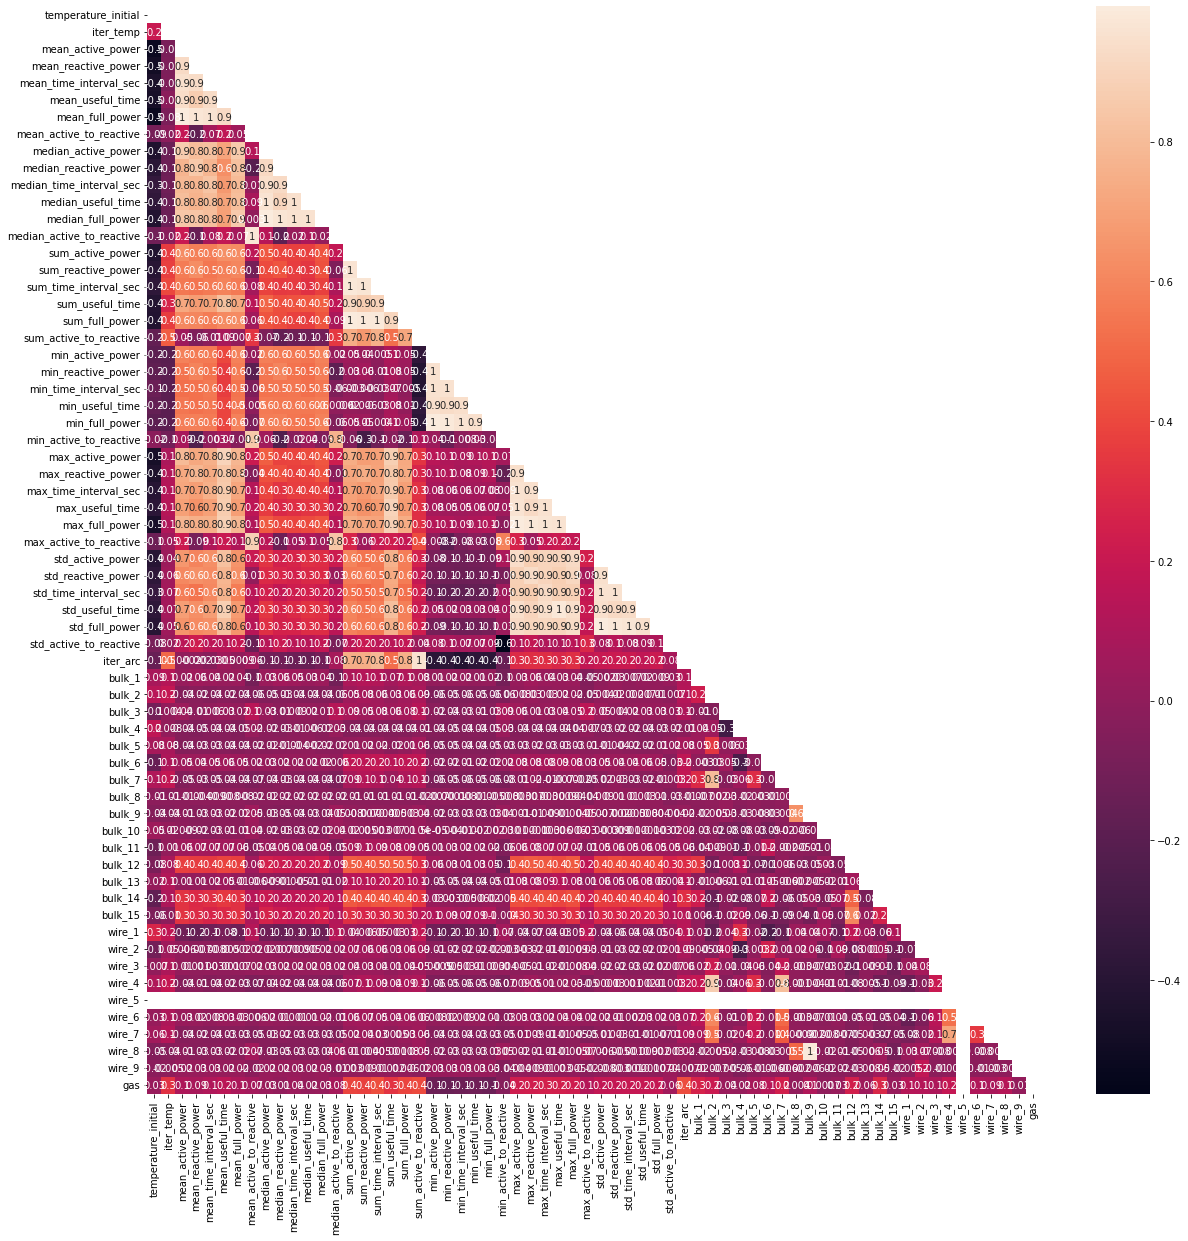

In [38]:
plt.figure(figsize=(20,20))
seaborn.heatmap(corr, annot = True, fmt='.1g', mask=np.triu(corr))


### Исключение признаков с высоким коэффициентом корреляции

In [39]:
multicol = get_corr_report(X_train, .9).sort_values('value', ascending=False)
multicol.sample(30, random_state=RANDOM_STATE)

feature1                  feature2    method     value
87         mean_useful_time           mean_full_power  spearman  0.958865
44         max_active_power           std_useful_time   pearson  0.940778
40         max_active_power     max_time_interval_sec   pearson  0.953072
31         min_active_power           min_useful_time   pearson  0.948754
112         sum_useful_time            max_full_power  spearman  0.910505
71       std_reactive_power     std_time_interval_sec   pearson  0.952997
111         sum_useful_time           max_useful_time  spearman  0.910977
174                  bulk_9                    wire_8   kendall  0.998873
165        min_active_power           min_useful_time   kendall  0.913742
122   min_time_interval_sec            min_full_power  spearman  0.964821
80        mean_active_power          mean_useful_time  spearman  0.964536
135      max_reactive_power           std_useful_time  spearman  0.929931
120      min_reactive_power            min_full_power  spearman  0.984642
73       std_reactive_power            std_full_power   pearson  0.979736
168         min_useful_time            min_full_power   kendall  0.915936
162     median_active_power         median_full_power   kendall  0.915789
25       sum_reactive_power            sum_full_power   pearson  0.984672
3         mean_active_power           mean_full_power   pearson  0.988880
68         std_active_power     std_time_interval_sec   pearson  0.953041
170        max_active_power            max_full_power   kendall  0.922813
14    median_reactive_power  median_time_interval_sec   pearson  0.924179
41         max_active_power           max_useful_time   pearson  0.957290
164      sum_reactive_power            sum_full_power   kendall  0.911920
114        min_active_power        min_reactive_power  spearman  0.958462
10      median_active_power     median_reactive_power   pearson  0.919200
16    median_reactive_power         median_full_power   pearson  0.967549
7    mean_time_interval_sec           mean_full_power   pearson  0.957261
63           max_full_power          std_active_power   pearson  0.925485
171         max_useful_time            max_full_power   kendall  0.910492
130        max_active_power            std_full_power  spearman  0.908504

In [40]:
multicol.shape[0]

175

Подавляющая часть признаков коррелирует друг с другом. Попытаемся для начала впрямую исключить наиболее взаимосвязанные


In [41]:
select_features(r_pipe, X_train, y_train)

0.05 8.461751726161232
0.1 8.466140664604254
0.15000000000000002 8.136781424913268
0.2 7.822021905014449
0.25 7.822021905014449
0.3 7.803060497833152
0.35000000000000003 7.674851028088003
0.4 7.556289013049155
0.45 7.38974116004246
0.5 7.38974116004246
0.55 6.7252985685754645
0.6000000000000001 6.680607542253684
0.6500000000000001 6.685815205164191
0.7000000000000001 6.685815205164191
0.7500000000000001 6.504402938317311
0.8 6.316688334729943
0.8500000000000001 6.266000964500558
0.9000000000000001 6.284423029823457
0.9500000000000001 6.283508721783515


(6.266000964500558,
 Index(['temperature_initial', 'iter_temp', 'median_full_power',
        'median_active_to_reactive', 'sum_full_power', 'min_full_power',
        'min_active_to_reactive', 'max_active_to_reactive', 'std_full_power',
        'std_active_to_reactive', 'iter_arc', 'bulk_1', 'bulk_3', 'bulk_4',
        'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_10', 'bulk_11', 'bulk_12',
        'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
        'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'gas'],
       dtype='object'))

Ничего не получается, признаки крепко сплетены в единую сеть и выхватыванием ее элементов мы лишь снижаем качество работы модели

### Селекция признаков на основе их важности
Попробуем подойти с другой стороны и определить вначале, какие признаки являются наиболее важными для работы модели, а затем удалить прочие, тем самым облегчив работу модели и возможно разрушив систему взаимосвязей между признаками

In [42]:
r_pipe.fit(X_train, y_train)
result = permutation_importance(r_pipe, X_train, y_train, n_jobs=-1,
                                random_state=RANDOM_STATE, n_repeats=5)
importances = pd.DataFrame({
    'importance': result.importances_mean,
    'feature': X_train.columns})
importances.sort_values(
    'importance', ascending=False).reset_index(drop=True).head()

importance              feature
0    1.695359       sum_full_power
1    1.429120      sum_useful_time
2    1.081215      std_useful_time
3    0.944803  temperature_initial
4    0.915927             iter_arc

In [43]:
fig = go.Figure(data=[go.Bar(x=importances.feature, y=importances.importance)])
fig.show()

Информация о сравнительной важности признаков ценна сама по себе и тут мы можем сообщить, что модель действительно вполне рационально и ожидаемо в первой тройке признаков  выделяет суммарную полную мощность, суммарное полезное время и среднеквадратическое отклонение по последнему. <br>
Для отбора признаков воспользуемся следующим алгоритмом: 
начнем накапливать в переменной признаки из  списка важности, начиная с наиболее важных и проверять, увеличивается ли качество на этом подмножестве с добавлением очередного признака. 
Если качество увеличилось, отбираем данный признак в другой список. Признаки, никак не повлиявшие на результат, при этом отобраны не будут. Остается вероятность кумулятивного действия малоэффективных признаков, которую мы просто оставим за скобками

In [44]:
X_train_selected = pd.DataFrame(index=X_train.index)
features_depo = pd.DataFrame(index=X_train.index)
score = 100.

for i, feature in enumerate(importances.feature):
    # Накапливает все фичи подряд
    features_depo = features_depo.join(X_train[feature])
    score_tmp = get_scores(r_pipe, features_depo, y_train, show=False)
    print(i, feature, score_tmp)
    if score_tmp < score:
        score = score_tmp
        # Сохраняет только результативные фичи
        X_train_selected = X_train_selected.join(X_train[feature])
        print('Улучшение результата с', feature)
        print('Сохранено признаков', len(X_train_selected.columns))

print('В итоге осталось признаков:', X_train_selected.shape[1])

0 temperature_initial 7.937616898030478
Улучшение результата с temperature_initial
Сохранено признаков 1
1 iter_temp 7.941678565771064
2 mean_active_power 7.74204175548965
Улучшение результата с mean_active_power
Сохранено признаков 2
3 mean_reactive_power 7.6599426520241005
Улучшение результата с mean_reactive_power
Сохранено признаков 3
4 mean_time_interval_sec 7.670209415439895
5 mean_useful_time 7.657364691312961
Улучшение результата с mean_useful_time
Сохранено признаков 4
6 mean_full_power 7.644523325473096
Улучшение результата с mean_full_power
Сохранено признаков 5
7 mean_active_to_reactive 7.650539933209641
8 median_active_power 7.6640624002112485
9 median_reactive_power 7.664437769510445
10 median_time_interval_sec 7.618835431389569
Улучшение результата с median_time_interval_sec
Сохранено признаков 6
11 median_useful_time 7.568931152470886
Улучшение результата с median_useful_time
Сохранено признаков 7
12 median_full_power 7.558965500256312
Улучшение результата с median_full

In [45]:
print('Взаимосвязанных признаков до обработки:',
      get_corr_report(X_train, .9).shape[0])
print('Взаимосвязанных признаков после обработки:',
      get_corr_report(X_train_selected, .9).shape[0])

Взаимосвязанных признаков до обработки: 175
Взаимосвязанных признаков после обработки: 22


<AxesSubplot:>

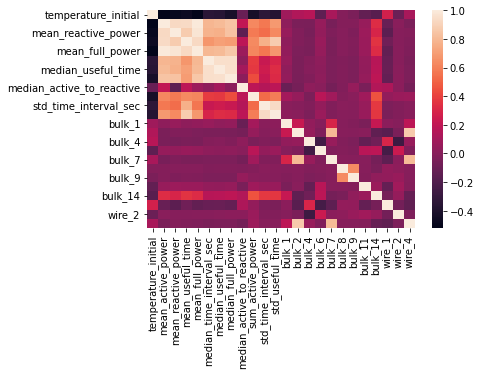

In [46]:
seaborn.heatmap(X_train_selected.corr())

In [47]:
get_scores(r_pipe, X_train_selected, y_train, show=False)

6.3043482156689485

Положение с мультиколинеарностью значительно улучшилось, но качество работы модели от этого не выиграло. Попробуем теперь избавиться от выбросов

### Детекция выбросов с помощью алгоритма изолирующего леса
Выбросы удалим отдельно из отобранных и не отобранных признаков

In [48]:
iforest = IsolationForest(random_state=RANDOM_STATE,
                          n_jobs=-1, n_estimators=500)
print('Отобранные признаки')
pred = iforest.fit_predict(X_train_selected)
labels = pd.DataFrame(data=pred, index=X_train_selected.index)
X_train_selected_outliers_free = X_train_selected[labels.values == 1]
y_train_selected_outliers_free = y_train[labels[labels.values == 1].index]

print('Найдено выбросов:', X_train_selected[labels.values == -1].shape[0])

Отобранные признаки
Найдено выбросов: 82


In [49]:
print('Неотобранные признаки')
pred = iforest.fit_predict(X_train)
labels = pd.DataFrame(data=pred, index=X_train.index)
X_train_outliers_free = X_train[labels.values == 1]
y_train_outliers_free = y_train[labels[labels.values == 1].index]

print('Найдено выбросов:', X_train[labels.values == -1].shape[0])

Неотобранные признаки
Найдено выбросов: 86


### Модель LightGBM


In [50]:
lgbm_regressor = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)
get_scores(lgbm_regressor, X_train, y_train, show=False)

6.278872623761642

In [51]:
datasets = [(X_train, y_train), (X_train_selected, y_train), (X_train_outliers_free,
                                                              y_train_outliers_free), (X_train_selected_outliers_free, y_train_selected_outliers_free)]
ridge_results = []
lgbm_results = []
names = ['plain', 'selected', 'no_outliers', 'selected_no_outliers']
for dataset in datasets:
    ridge_results.append(get_scores(r_pipe, *dataset, show=False))
    lgbm_results.append(get_scores(lgbm_regressor, *dataset, show=False))
results = {'Ridge': ridge_results, 'LGBM': lgbm_results}
pd.DataFrame(data=results, index=names)

Ridge      LGBM
plain                 6.221928  6.278873
selected              6.304348  6.563044
no_outliers           6.029408  6.034665
selected_no_outliers  6.128626  6.158331

### Настройка гиперпараметров


In [52]:
def r_objective(trial):
    params = {
        'regressor__alpha': trial.suggest_float('regressor__alpha', .0001, 15.9)
    }
    r_pipe.set_params(**params)
    return get_scores(r_pipe, X_train_outliers_free, y_train_outliers_free, show=False)


study = optuna.create_study(direction='minimize')
study.optimize(r_objective, n_trials=20)
r_best_params = study.best_params

[I 2023-03-31 16:53:50,291] A new study created in memory with name: no-name-5e623646-363c-4c6d-b448-b540f7afcc25
[I 2023-03-31 16:53:50,337] Trial 0 finished with value: 6.031506030423219 and parameters: {'regressor__alpha': 2.8938193169237407}. Best is trial 0 with value: 6.031506030423219.
[I 2023-03-31 16:53:50,379] Trial 1 finished with value: 6.048114626701051 and parameters: {'regressor__alpha': 12.5835932411829}. Best is trial 0 with value: 6.031506030423219.
[I 2023-03-31 16:53:50,427] Trial 2 finished with value: 6.030891357645757 and parameters: {'regressor__alpha': 2.5974556991382802}. Best is trial 2 with value: 6.030891357645757.
[I 2023-03-31 16:53:50,477] Trial 3 finished with value: 6.044213881404311 and parameters: {'regressor__alpha': 10.094870892563138}. Best is trial 2 with value: 6.030891357645757.
[I 2023-03-31 16:53:50,524] Trial 4 finished with value: 6.041230152880748 and parameters: {'regressor__alpha': 8.28265620988244}. Best is trial 2 with value: 6.0308913

In [53]:
def lgbm_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 64),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 333),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'n_estimators': trial.suggest_int('n_estimators ', 2000, 8000),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.01, 0.02, 0.05, 0.1]),
    }
    lgbm_regressor.set_params(**params)
    return get_scores(lgbm_regressor, X_train_outliers_free, y_train_outliers_free, show=False)


study = optuna.create_study(direction='minimize')
study.optimize(lgbm_objective, n_trials=20)
lgbm_best_params = study.best_params

[I 2023-03-31 16:53:51,259] A new study created in memory with name: no-name-c291a0de-b552-4e03-8787-16636b8c8133
[I 2023-03-31 16:54:11,366] Trial 0 finished with value: 6.394606837929614 and parameters: {'max_depth': 38, 'reg_alpha': 7.679160952102686, 'reg_lambda': 9.022237745807187, 'num_leaves': 81, 'min_child_samples': 91, 'n_estimators ': 6650, 'learning_rate': 0.02}. Best is trial 0 with value: 6.394606837929614.
[I 2023-03-31 16:54:17,963] Trial 1 finished with value: 6.260304007762381 and parameters: {'max_depth': 20, 'reg_alpha': 8.099412025991901, 'reg_lambda': 9.203023048522667, 'num_leaves': 74, 'min_child_samples': 50, 'n_estimators ': 5541, 'learning_rate': 0.05}. Best is trial 1 with value: 6.260304007762381.
[I 2023-03-31 16:54:22,188] Trial 2 finished with value: 6.335966756299834 and parameters: {'max_depth': 22, 'reg_alpha': 9.850084135478061, 'reg_lambda': 2.635826068202777, 'num_leaves': 155, 'min_child_samples': 53, 'n_estimators ': 7259, 'learning_rate': 0.1}. 

In [54]:
r_pipe.set_params(**r_best_params)
lgbm_regressor.set_params(**lgbm_best_params)
get_scores(r_pipe, X_train_outliers_free, y_train_outliers_free, show=False, simple_response=False).describe()\
    .join(get_scores(lgbm_regressor, X_train_outliers_free, y_train_outliers_free, show=False, simple_response=False).describe(), lsuffix='_ridge', rsuffix='_lgbm')

fit_time_ridge  score_time_ridge  test_score_ridge  train_score_ridge  \
count        5.000000          5.000000          5.000000           5.000000   
mean         0.025596          0.004794          5.581774           5.392253   
std          0.020605          0.001092          0.342319           0.090340   
min          0.009014          0.003000          5.091768           5.282877   
25%          0.009979          0.004978          5.497401           5.345846   
50%          0.013006          0.004999          5.564038           5.377235   
75%          0.044996          0.005004          5.726358           5.434547   
max          0.050985          0.005990          6.029308           5.520761   

       fit_time_lgbm  score_time_lgbm  test_score_lgbm  train_score_lgbm  
count       5.000000         5.000000         5.000000          5.000000  
mean       29.376479         0.775697         5.673221          0.929331  
std         0.286921         0.047810         0.436942          0.037915  
min        28.960754         0.709756         4.923057          0.876795  
25%        29.253369         0.742134         5.713313          0.914803  
50%        29.455378         0.794304         5.784014          0.922589  
75%        29.485376         0.811139         5.911719          0.964001  
max        29.727518         0.821150         6.034003          0.968467

In [55]:
pd.DataFrame({'importance': r_pipe.named_steps['regressor'].coef_},
    index=r_pipe.named_steps['regressor'].feature_names_in_)\
    .sort_values(by='importance', key=(lambda x: np.abs(x)), ascending=False)                                                                                                    .head(3)

importance
max_active_to_reactive   -8.462879
sum_full_power            5.744995
sum_reactive_power       -5.290168

Возьмем в расчет, что
- модель на основе гребневой регрессии в любом случае показывает качество работы не хуже бустера
- при этом она гораздо быстрее
- не переобучается
- дает более стабильный результат

Выбор вполне очевиден, мы рекомендуем для решения задачи прогнозирования температуры расплавленной стали в процессе легирования модель на основе гребневой регрессии в сочетании с предобработанными данными. В конце проведем последнее испытание на части выборки, специально выделенной для  этой цели.

## Финальное тестирование


In [56]:
r_pipe.fit(X_train_outliers_free, y_train_outliers_free)
predictions = r_pipe.predict(X_test)
mean_absolute_error(y_test, predictions)

5.957479654349484

In [57]:
print('Лучшая модель:')
r_pipe.steps[1][1]

Лучшая модель:


Ridge(alpha=1.0531035813312333, random_state=270223)

Модель на основе алгоритма гребневой регрессии успешно прошла финальные испытания на неизмененных данных и может быть рекомендована для дальнейшего использования.
### Выводы по этапу работы с моделями

Итак, в этой части работы мы создали по экземпляру моделей на основе ридж-регрессии и градиентного бустинга, обучили и провалидировали, провели ряд дополнительных мероприятий с целью добиться лучшего качества  их прогноза
В ходе дополнительной обработки мы в итоге получили четыре набора обучающих данных и сравнили результаты по ним для обеих моделей
Была изучена мультиколинеарность среди признаков и выделены наиболее важные среди них.
Был проведен поиск и удаление выбросов
С помощью инструмента optuna была проведена автоматизированная настройка гиперпараметров моделей.
В конце была выбрана модель на основе гребневой регрессии, показавшая стабильную работу на кросс-валидации с необходимым уровнем качества, полностью сохранившимися в ситуации финального испытания на тестовых данных


## Отчет

Целью настоящей работы было создание прототипа модели машинного обучения для прогноза конечной температуры расплава в процессе легирования стали для оптимизации энергозатрат на металлургическом предприятии.
В начале  работы были загружены и изучены данные по работе электродов, датчиков температуры, бункеров сыпучих материалов и трайб-аппарата, подаче  инертного газа.
В ходе исследовательского анализа было подтверждено, что технологический процесс протекает не вполне оптимально и разработка инструмента для лучшего контроля за ним оправдана.
Далее был составлен план действий, реализованный на последующих шагах с изложенными ниже результатами:
1. Данные были сведены в один общий датасет, при этом было осуществлено:
    1. именование признаков в стандартном виде
    2. удаление отсутствующих в некоторых таблицах ключей
    3. удаление аномалий по заданным условиям
    4. заполнение пропусков нулевыми значениями
    5. добавление вычисляемых признаков на основе имеющихся
    6. агрегация значений признаков на различных итерациях в единое для одного ключа с помощью набора функций
2. Был выделен целевой признак и данные были разделены на обучающую и тестовую выборки в заданной по условию задания пропорции
3. Был введен порог вменяемости в виде средней абсолютной ошибки для  среднего значения целевого признака в обучающей выборке и целевого признака в тестовой выборке
4. Для модели на основе алгоритма гребневой регрессии была осуществлена попытка отбора признаков, для чего:
    1. была исследована структура мультиколинеарности имеющихся признаков
    2. были найдены наиболее важные признаки на основе пермутации
    3. различными способами было выделено подмножество признаков с меньшей степенью взаимосвязанности и/или с большим влиянием каждого из них на качество работы модели
    4. в конечном итоге все эти мероприятия не дали ощутимого прироста качества модели и были найдены избыточными
5. На основе алгоритма изолирующего леса были найдены и удалены выбросы, что дало некоторый прирост качества работы как модели гребневой регрессии, так и введенной на данном этапе модели на основе градиентного бустинга
6. Была проведена настройка  гиперпараметров обеих моделей, в случае с гребневой регрессией не давшая ощутимых результатов (значение коэффициента регуляризации 1.358196270465704)
7. Были сравнены результаты работы  обеих моделей с помощью  кросс-валидации на обучающей выборке, что позволило сделать следующие выводы:
    1. Среднее качество работы обеих моделей по метрике MAE на валидационных фрагментах различается несущественно
    2. модель на основе гребневой регрессии практически не переобучается (близкие средние значения MAE на обучающих (5.394023) и валидационных (5.572862) фрагментах
    3. у модели на основе гребневой регрессии стандартное отклонение на валидационных фрагментахменьше такового  у модели на основе градиентного бустинга: 0.345731 против 0.431012
    4. модель на основе гребневой регрессии работает значительно быстрее (средняя скорость обучения и прогнозирования 0.013858 и 0.004132 соответственно против 4.458170 и 0.028530)
8. Учитывая эти моменты наряду с тем, что обе модели дают необходимый уровень точности по условию задания, в итоге была выбрана модель на основе алгоритма гребневой регрессии  - с коэффициентом регуляризации 1.358196270465704, обученная на тренировочных данных с удаленными ввыбросами без масштабирования. 
9. Было проведено финальное тестирование на заранее отобранной случайным образом проверочной выборке, которое полностью подтвердило работоспособность выбранной модели (значение MAE 5.9573122796560884)

В данном случае средняя абсолютная ошибка является отклонением прогноза от реальной величины в градусах Цельсия. Таким образом, наша модель допускает ошибку при прогнозе конечной температуры расплава в пределах менее шести градусов. 
Также к достоинствам данной модели относится интерпретируемость результатов, в частности, на основе изучения полученных весов можно утверждать, что к трем наиболее значимым для формирования прогноза признакам относятся:
- максимальное  соотношение активной и реактивной мощности по всем итерациям
- суммарная полная мощность
- суммарная реактивная мощность

Эта модель  на основе проведенного исследования рекомендуется в качестве наиболее адекватной из обоих рассмотренных для решения предложенной задачи.

План мероприятий, таким образом, был полностью реализован и цель работы успешно достигнута.